In [2]:
import MDAnalysis as mda
from ARPDF import *

Computed field for ('C', 'C'), 51 atom pairs.
Computed field for ('C', 'CL'), 300 atom pairs.
Computed field for ('CL', 'CL'), 415 atom pairs.
Computed field for ('C', 'C'), 49 atom pairs.
Computed field for ('C', 'CL'), 302 atom pairs.
Computed field for ('CL', 'CL'), 413 atom pairs.


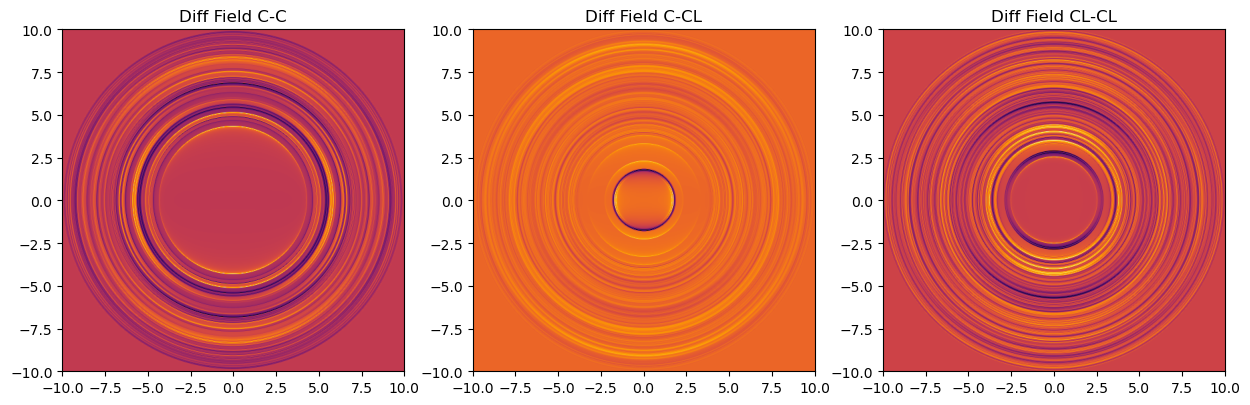

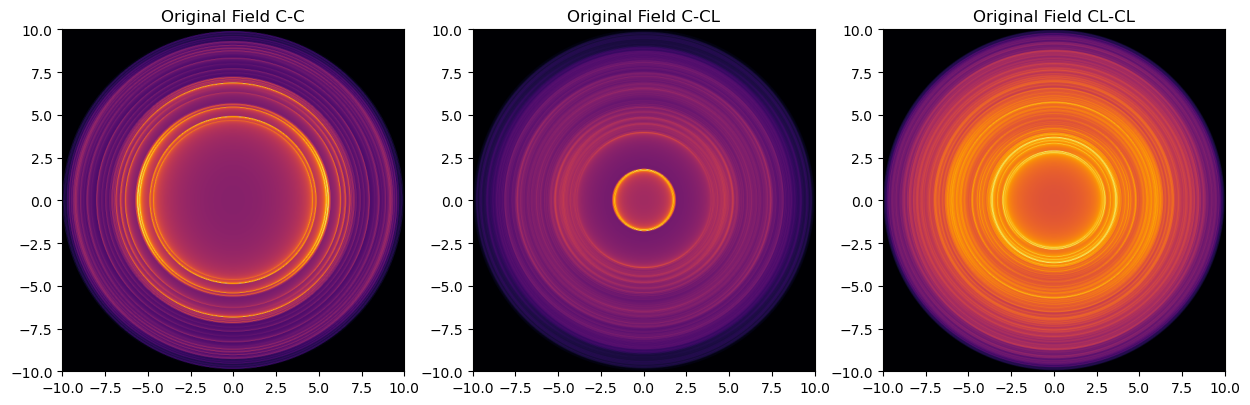

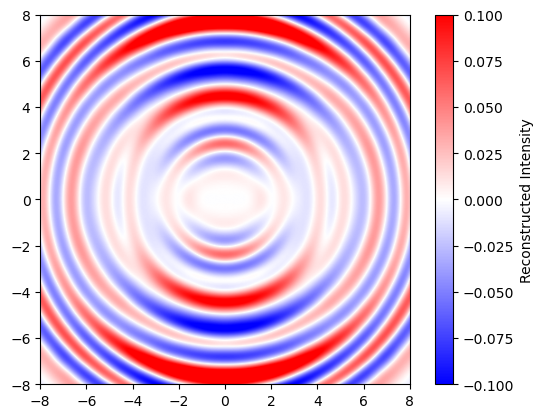

In [5]:
u1 = mda.Universe('data/CCl4/CCl4.gro')
u2 = mda.Universe('data/CCl4/CCl4_modified.gro')
modified_atoms = [515, 516, 517, 518, 519, 645]
polar_axis = [0.85692924,0.47545751,0.19902873]
ARPDF = compute_ARPDF(u1, u2, cutoff=10.0, N=512, modified_atoms=modified_atoms, 
                        polar_axis=polar_axis, periodic=True, verbose=True)

In [4]:
import time
start = time.time()
num_iter = 500
for _ in range(num_iter):
    compute_ARPDF(u1, u2, cutoff=10.0, N=512, modified_atoms=modified_atoms, polar_axis=(0, 0, 1), periodic=True, verbose=False)
print("Time for compute_ARPDF:", (time.time() - start) / num_iter)

Time for compute_ARPDF: 0.03343707323074341
